# Skin Cancer Identifier 
# Author: Owen Trudt

In [1]:
# imports
import os 
import pandas as pd 
import sklearn 
import tensorflow as tf 
import numpy as np 
import shutil
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import glob
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [28]:
# Larger Data Set BEGIN


train_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/train/"
test_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/test/"



train_dg = ImageDataGenerator(
    rescale=1./255, 
    
)

test_dg = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_dg.flow_from_directory(
    train_dir, 
    seed=100, 
    target_size=(224,224), 
    batch_size=20, 
    class_mode='binary'
)

test_gen = test_dg.flow_from_directory(
    test_dir, 
    seed=100, 
    target_size=(224,224), 
    batch_size=20, 
    class_mode='binary'
)



Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [51]:
from keras.layers import BatchNormalization
# we will still be using vgg19 

base_model = VGG19(
    include_top=False, 
    input_shape=(224, 224, 3),
    weights='imagenet' 
)

for layer in model.layers: 
    layer.trainable = False 


inputs = keras.Input(shape=(224, 224, 3))
data_aug_layer = keras.Sequential(
    [keras.layers.RandomFlip(mode="horizontal"),
     keras.layers.RandomRotation(fill_mode="reflect", factor=0.1),
     keras.layers.RandomZoom(-0.1),
     ]
)
x = data_aug_layer(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.8)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

fin_modelv2 = keras.Model(base_model.input, outputs)

fin_modelv2.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(from_logits=True), 
                    metrics=[keras.metrics.BinaryAccuracy()])




Also I am a little rusty so there might be some things wrong with this model that do not make sense. I am trying to relearn this material and no better way to relearn then trying to solve a problem :) 

In [52]:
checkpoint = ModelCheckpoint('vgg19_best_model.keras', monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

In [53]:
historyv2 = fin_modelv2.fit(
        train_gen,
        epochs=10,
        validation_data=test_gen,
        callbacks=[checkpoint, EarlyStopping(patience=4)]
)

Epoch 1/10


c:\Users\ot7sl\Favorites\repo_house\PersonalProjects\venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.7153 - loss: 0.6882
Epoch 1: val_binary_accuracy improved from -inf to 0.45455, saving model to vgg19_best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 665s 5s/step - binary_accuracy: 0.7155 - loss: 0.6879 - val_binary_accuracy: 0.4545 - val_loss: 3.7094
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - binary_accuracy: 0.7733 - loss: 0.5442
Epoch 2: val_binary_accuracy improved from 0.45455 to 0.54545, saving model to vgg19_best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 919s 7s/step - binary_accuracy: 0.7732 - loss: 0.5443 - val_binary_accuracy: 0.5455 - val_loss: 5.7914
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.7789 - loss: 0.4810
Epoch 3: val_binary_accuracy did not improve from 0.54545
132/132 ━━━━━━━━━━━━━━━━━━━━ 852s 6s/step - binary_accuracy: 0.7789 - loss: 0.4809 - val_binary_accuracy: 0.5455 - val_loss: 8.6017
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.7694 - l

# Lets try a different approach, lets do some feature engineering on the images.
These images are similar so if we do some feature extraction we can possibly see some performance gains.
The idea is that I want the initial cnn architecture (with improvements of course because this model is not working well)
but then incorporate a glcm layer? 
Still figuring this out... this is a new technqiue to me

glcm is good for texture, I am working off of the assumption and after looking at some images there will be a texture difference between a benign and malignant skin tag

special s/o to this notebook: https://www.kaggle.com/code/cholisah/my-glcm-and-cnn/notebook, https://www.kaggle.com/code/kevinismail/pneumonia-covid19-classification-with-glcm-and-cnn
I haven't done combinded models before and this notebook basically is the idea I had for this problem so I will be following a similar structure. 

In [2]:
import cv2
from skimage.feature import graycomatrix, graycoprops
from keras.callbacks import ReduceLROnPlateau

In [3]:
def glcm_extraction(images): 
    image_data = pd.DataFrame()
    for image in images: 
        df = pd.DataFrame()

        distance = [[1], [3], [5], [3], [3], [7]]
        angles = [[0], [0], [0], [np.pi/4], [np.pi/2]]

        for n, (dist, angle) in enumerate(zip(distance, angles)): 
            glcm = graycomatrix(image, dist, angle)
            glcm_e = graycoprops(glcm, 'energy')[0]
            df['Energy'+str(n)] = glcm_e
            glcm_corr = graycoprops(glcm, 'correlation')[0]
            df['Corr'+str(n)] = glcm_corr       
            glcm_diss = graycoprops(glcm, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = glcm_diss       
            glcm_homm = graycoprops(glcm, 'homogeneity')[0]
            df['Homogen'+str(n)] = glcm_homm       
            glcm_contr = graycoprops(glcm, 'contrast')[0]
            df['Contrast'+str(n)] = glcm_contr
        
        image_data = pd.concat([image_data, df], ignore_index=True)

    return image_data 



In [4]:
train_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/train/"
test_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/test/"

# np array images 
categories_dict = {
  "benign": 0,
  "malignant": 1
}


SIZE = 140
BATCH_SIZE = 32
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 50
STEP_SIZE = 70



In [5]:
train_images = []
train_labels = [] 
label = 0
images = []

for directory in os.listdir(train_dir): 
    label = categories_dict[directory]
    for img_path in glob.glob(os.path.join(train_dir+"/"+str(directory), "*.jpg")): 
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        train_images.append(img)
        train_labels.append(label)
print(len(train_images))
print(len(train_labels))

2637
2637


In [6]:
test_images = []
test_labels = [] 
test_labels_test = []
label = 0
images = []

for directory in os.listdir(test_dir): 
    label = categories_dict[directory]
    for img_path in glob.glob(os.path.join(test_dir+"/"+str(directory), "*.jpg")): 
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        test_images.append(img)
        test_labels.append(label)
        test_labels_test.append(label)
print(len(test_images))
print(len(test_labels))
test_images = np.array(test_images)

660
660


In [7]:
x_train = np.array(train_images)

In [8]:
train_images, val_images, train_labels, val_labels = train_test_split(x_train, train_labels, test_size=0.15, random_state=1)

In [9]:
print("train:",train_images.shape[0])
print("val:", val_images.shape[0])
print("test:", test_images.shape[0])

train: 2241
val: 396
test: 660


In [10]:
 train_features = glcm_extraction(train_images)
 test_features = glcm_extraction(test_images)
 val_features = glcm_extraction(val_images)

In [11]:
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [12]:
pd.set_option("display.max_columns", None)
train_features

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.051216,0.987535,2.447482,0.352394,11.656321,0.042345,0.957208,4.350469,0.245746,40.500313,0.038955,0.921011,5.754444,0.212411,75.633069,0.044290,0.969667,3.745537,0.269056,28.783239,0.046108,0.976399,3.330188,0.290182,22.319030
1,0.067511,0.968860,2.695786,0.391367,26.237102,0.052996,0.925422,4.733785,0.267703,63.625756,0.048074,0.877818,6.114550,0.223331,105.605556,0.054728,0.937331,4.329815,0.281282,53.752836,0.059208,0.945754,3.860219,0.313691,46.233733
2,0.017500,0.974720,6.643474,0.159976,93.205961,0.013836,0.924913,12.206674,0.089574,275.705839,0.012798,0.877107,15.766772,0.073194,449.413228,0.014553,0.944236,10.472432,0.103759,201.873398,0.015132,0.951186,9.618926,0.113264,180.702972
3,0.050792,0.993525,3.234789,0.354816,26.926362,0.037213,0.972128,7.115381,0.199387,117.333942,0.032124,0.942770,10.507989,0.142589,243.855820,0.039959,0.979746,5.882220,0.242926,85.504043,0.040914,0.979510,5.739520,0.260140,85.811783
4,0.043963,0.908811,4.260534,0.251521,52.724666,0.036441,0.718544,6.846194,0.174677,154.543379,0.034528,0.586806,7.990688,0.151766,216.134815,0.037362,0.785981,6.291535,0.182546,115.850872,0.038595,0.844899,5.753493,0.192229,87.730031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236,0.048403,0.991183,2.821480,0.296933,13.691984,0.039945,0.971695,5.038738,0.192467,44.411105,0.037504,0.950940,6.518413,0.159112,77.771746,0.040907,0.976907,4.603025,0.200847,36.356753,0.040260,0.975796,4.722002,0.194454,37.886966
2237,0.043484,0.973684,2.518140,0.362654,21.342292,0.032439,0.917245,4.930918,0.213526,66.191397,0.028785,0.849338,6.769101,0.157209,119.293545,0.033750,0.934233,4.469492,0.228803,52.978208,0.033649,0.928667,4.468092,0.239931,58.188425
2238,0.046266,0.960559,3.820349,0.255497,30.386742,0.038774,0.908745,6.199583,0.169964,71.148071,0.037159,0.865578,7.526720,0.146545,106.080899,0.039951,0.926302,5.457519,0.187454,57.709462,0.042632,0.945764,4.629458,0.214383,42.195464
2239,0.061587,0.990306,2.235920,0.377004,9.763258,0.047157,0.960685,4.400886,0.233663,40.095464,0.042739,0.923654,5.951481,0.186965,78.821111,0.048558,0.967036,4.086484,0.245759,33.790433,0.051865,0.975339,3.526642,0.276988,25.149583


In [13]:
from keras import Input
glcm_model_input = Input(shape=(25,))
x1 = keras.layers.Dense(64, activation='relu')(glcm_model_input)
x1 = keras.layers.Dense(32, activation='relu')(x1)
x1 = keras.layers.Dense(16, activation='relu')(x1)

In [14]:
from keras.regularizers import l2

cnn_input = Input((140,140,1))
x2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.001))(cnn_input)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.MaxPool2D(pool_size=(5,5))(x2)
x2 = keras.layers.Dropout(0.2)(x2)

x2 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.001))(x2)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.GlobalAveragePooling2D()(x2)
x2 = keras.layers.Dense(256, activation='relu')(x2)
x2 = keras.layers.Dropout(0.2)(x2)



In [15]:
combined = keras.layers.Concatenate()([x1, x2])
x = keras.layers.Dense(128, activation='relu')(combined)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)



In [16]:
model = keras.Model([glcm_model_input, cnn_input], x)

In [17]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 140, 140,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 138, 138,  │      1,280 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 138, 138,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 27, 27,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 27, 27,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 25,    │     36,896 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,664 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 272)       │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     34,944 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_3[0][0] 

 Total params: 97,361 (380.32 KB)

 Trainable params: 97,041 (379.07 KB)

 Non-trainable params: 320 (1.25 KB)

None


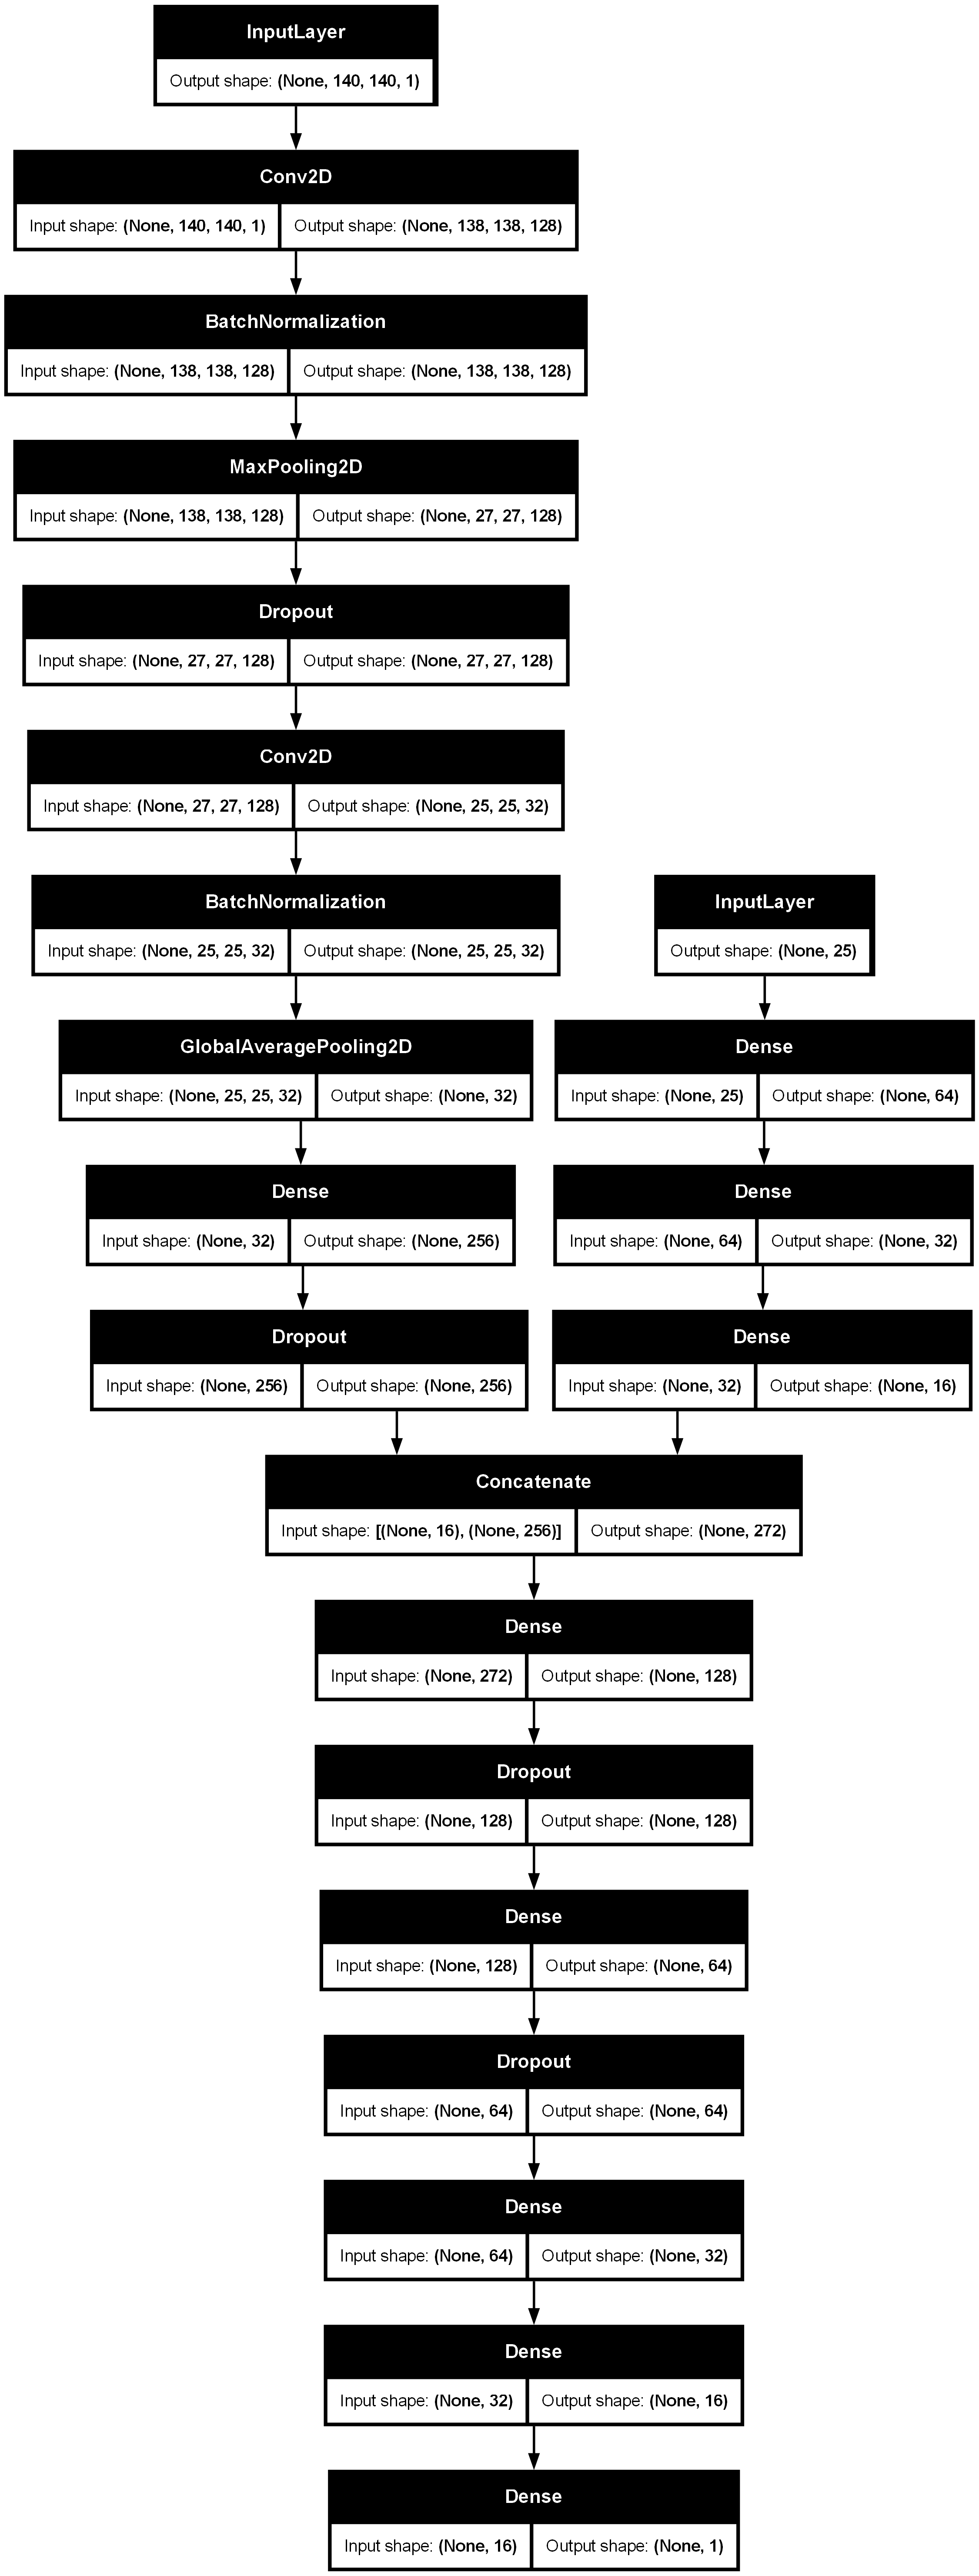

In [18]:
from keras.utils import plot_model
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

plot_model(model, to_file='glcm_cnn_model.png',  show_shapes=True)

In [32]:
aopt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=aopt, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
                    metrics=[keras.metrics.BinaryAccuracy()])

In [33]:
callb = [
    ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=10,
    mode='auto',
    min_delta=0.0002,
    cooldown=5, 
    min_lr=10e-8,
    verbose=1,
    ), 
    EarlyStopping(
            monitor='val_loss',
            patience=10, 
        
    ), 
    ModelCheckpoint(
        'glcm_cnn_model_best.keras', 
        monitor='val_binary_accuracy', 
        verbose=1, 
        save_best_only=True, 
        mode='max')
        ]

In [21]:
data_inputs = tf.data.Dataset.from_tensor_slices((train_features, tf.expand_dims(train_images_norm, axis=-1)))
data_labels = tf.data.Dataset.from_tensor_slices(train_labels)

val_inputs = tf.data.Dataset.from_tensor_slices((val_features, tf.expand_dims(val_images_norm, axis=-1)))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels)

val_dataset = tf.data.Dataset.zip((val_inputs, val_labels)).batch(BATCH_SIZE).repeat()

dataset = tf.data.Dataset.zip((data_inputs, data_labels)).batch(BATCH_SIZE).repeat()

In [34]:
historyv3 = model.fit(dataset, validation_data=val_dataset, validation_steps=(len(val_features) // BATCH_SIZE) ,epochs=EPOCH_NUM, steps_per_epoch=STEP_SIZE, callbacks=callb)

Epoch 1/50


c:\Users\ot7sl\Favorites\repo_house\PersonalProjects\venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - binary_accuracy: 0.6773 - loss: 0.6569
Epoch 1: val_binary_accuracy improved from -inf to 0.46094, saving model to glcm_cnn_model_best.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 315ms/step - binary_accuracy: 0.6774 - loss: 0.6566 - val_binary_accuracy: 0.4609 - val_loss: 0.8018 - learning_rate: 0.0050
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - binary_accuracy: 0.6246 - loss: 0.6326
Epoch 2: val_binary_accuracy improved from 0.46094 to 0.49176, saving model to glcm_cnn_model_best.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - binary_accuracy: 0.6245 - loss: 0.6328 - val_binary_accuracy: 0.4918 - val_loss: 0.7052 - learning_rate: 0.0050
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - binary_accuracy: 0.6296 - loss: 0.6568
Epoch 3: val_binary_accuracy did not improve from 0.49176
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - binary_accuracy: 0.6301 - loss: 0.6565 - val_binary_accuracy: 0.4615 - val_loss: 0.7562 - learning_rate: 0.0050

In [23]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

In [35]:
score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test binary accuracy: {score[1]}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - binary_accuracy: 0.7043 - loss: 0.4944
Test loss: 0.5064294338226318 / Test binary accuracy: 0.734375


In [36]:
historyv3.history.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss', 'learning_rate'])

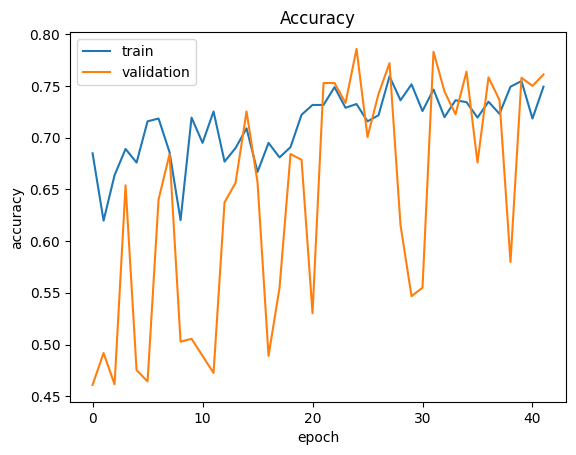

In [37]:
plt.plot(historyv3.history['binary_accuracy'])
plt.plot(historyv3.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

C:\Users\ot7sl\AppData\Local\Temp\ipykernel_14464\1302444967.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


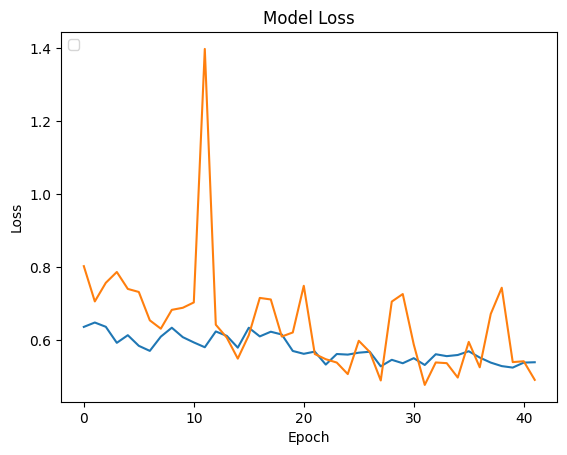

In [38]:
plt.plot(historyv3.history['loss'])
plt.plot(historyv3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [39]:
# ROC / AUC

preds = model.predict(test_dataset, steps=STEP_SIZE_TEST, batch_size=BATCH_SIZE)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


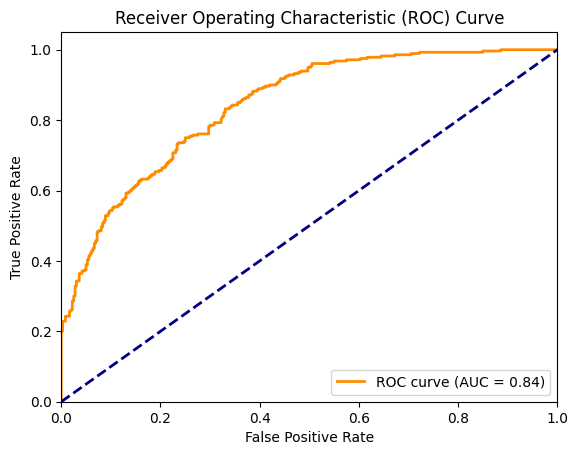

In [40]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_labels_test[:640], preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
rounded_array = np.where(preds >= 0.5, 1, 0)

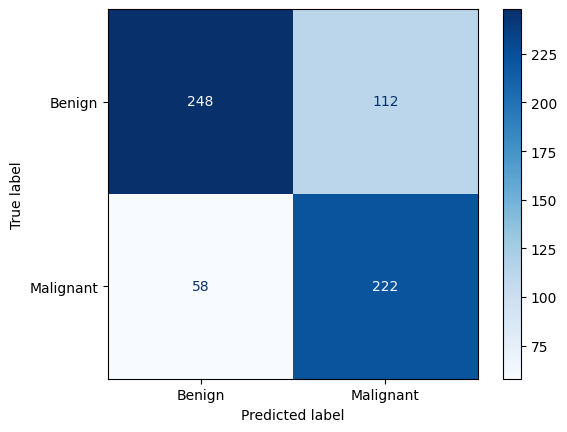

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels_test[:640], rounded_array, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap=plt.cm.Blues, values_format='d')

FPR: 0.189 ~ 20% 
Goal to minimize this as much as possible 